# Predicting Online Sales Revenues: Trees and Forests
In this notebook we test the performance of five models, a simple decision tree, a decision tree with cross validation, random forests, boosted trees and stacking of all the four models.

We came to the conclusion that boosted trees, random forests and stacking performed better than simple trees and CV-trees. Although the forests and the stacking seem to perform better by the slightest margin according to the lift curve we opted for the boosted tree since it performs almost equally well but has the clear advantage of significantly shorter runtime (ca. 8 seconds compared to 10-15 min).

Hence our model for the classification will be the boosted tree 

We also experimented with variable selection using the Recursive Feature Elimination from sklearn, but the model performs better without a reduction of variables so we decided to keep all of them since 18 features is not too much. 

1. Simple decision tree
2. Decision tree with cross validation
3. Random forest
4. Boosted tree
5. Stacking of all models 

## Setup

### Import (Standard) Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Import Data

In [2]:
data = pd.read_csv("../Data/clean_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  float64
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  float64
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  float64
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  Month                          12330 non-null  float64
 11  OperatingSystems               12330 non-null  float64
 12  Browser                        12330 non-null 

### Set up relevant functions

In [3]:
#function for the lift curve
def calculate_lift(y_val, y_pred):
    from pandas import DataFrame
    from numpy import ceil, arange
    
    #Define an auxiliar dataframe to plot the curve
    aux_lift = DataFrame()
    aux_lift['true'] = y_val
    aux_lift['predicted'] = y_pred
    aux_lift.sort_values('predicted', ascending=False, inplace=True)
    
    #Create the values that will go into the X axis of our plot
    xval = arange(0.01,1.01,0.01) #create sequnence of values from 0.01 to 1.00 in steps of 0.01
    lift = [] #create empty list for storing lift values
    
    #Calculate the total ratio of true events in the data
    ratio_true_events_total = aux_lift['true'].sum() / len(aux_lift)
    
    #Calculate lift for each x value its correspondent y value
    for x in xval:
        index_xval = int(ceil(x*len(aux_lift))) #get index at specific value of x
        dataframe_xval = aux_lift.iloc[:index_xval,:]   #subset dataframe from 0 to index_val
        lift_xval = dataframe_xval['true'].sum()/len(dataframe_xval) #calculate lift for subset
        lift.append(lift_xval / ratio_true_events_total) #store results
    
    return (DataFrame({"Lift":lift, "ProportionSample":xval}))

## Training and Evaluating a Decision Tree Classifier

### 1) Import Model Functions

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2) Define X and y

In [5]:
# create one final testing set to compare performance of our best model for unseen data 
data, test_data = train_test_split(data, test_size=0.1, random_state=1)

In [8]:
y = data["Revenue"]
X = data.drop("Revenue", axis=1)

### 3) Create Test & Training Data


In [9]:
# we will use this train and test set througout the notebook
y = data["Revenue"]
X = data.drop("Revenue", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

### 4) Instantiate and Fit Model  

In [21]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 2).fit(X_train, y_train)


### 5) Interpret Results


In [22]:
def plot_tree_classification(treemodel, X):
    from sklearn import tree
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(60,20))
    _ = tree.plot_tree(treemodel,filled=True,
                       class_names=['0','1'],
                       feature_names = X.columns,
                       proportion=True,precision=2)

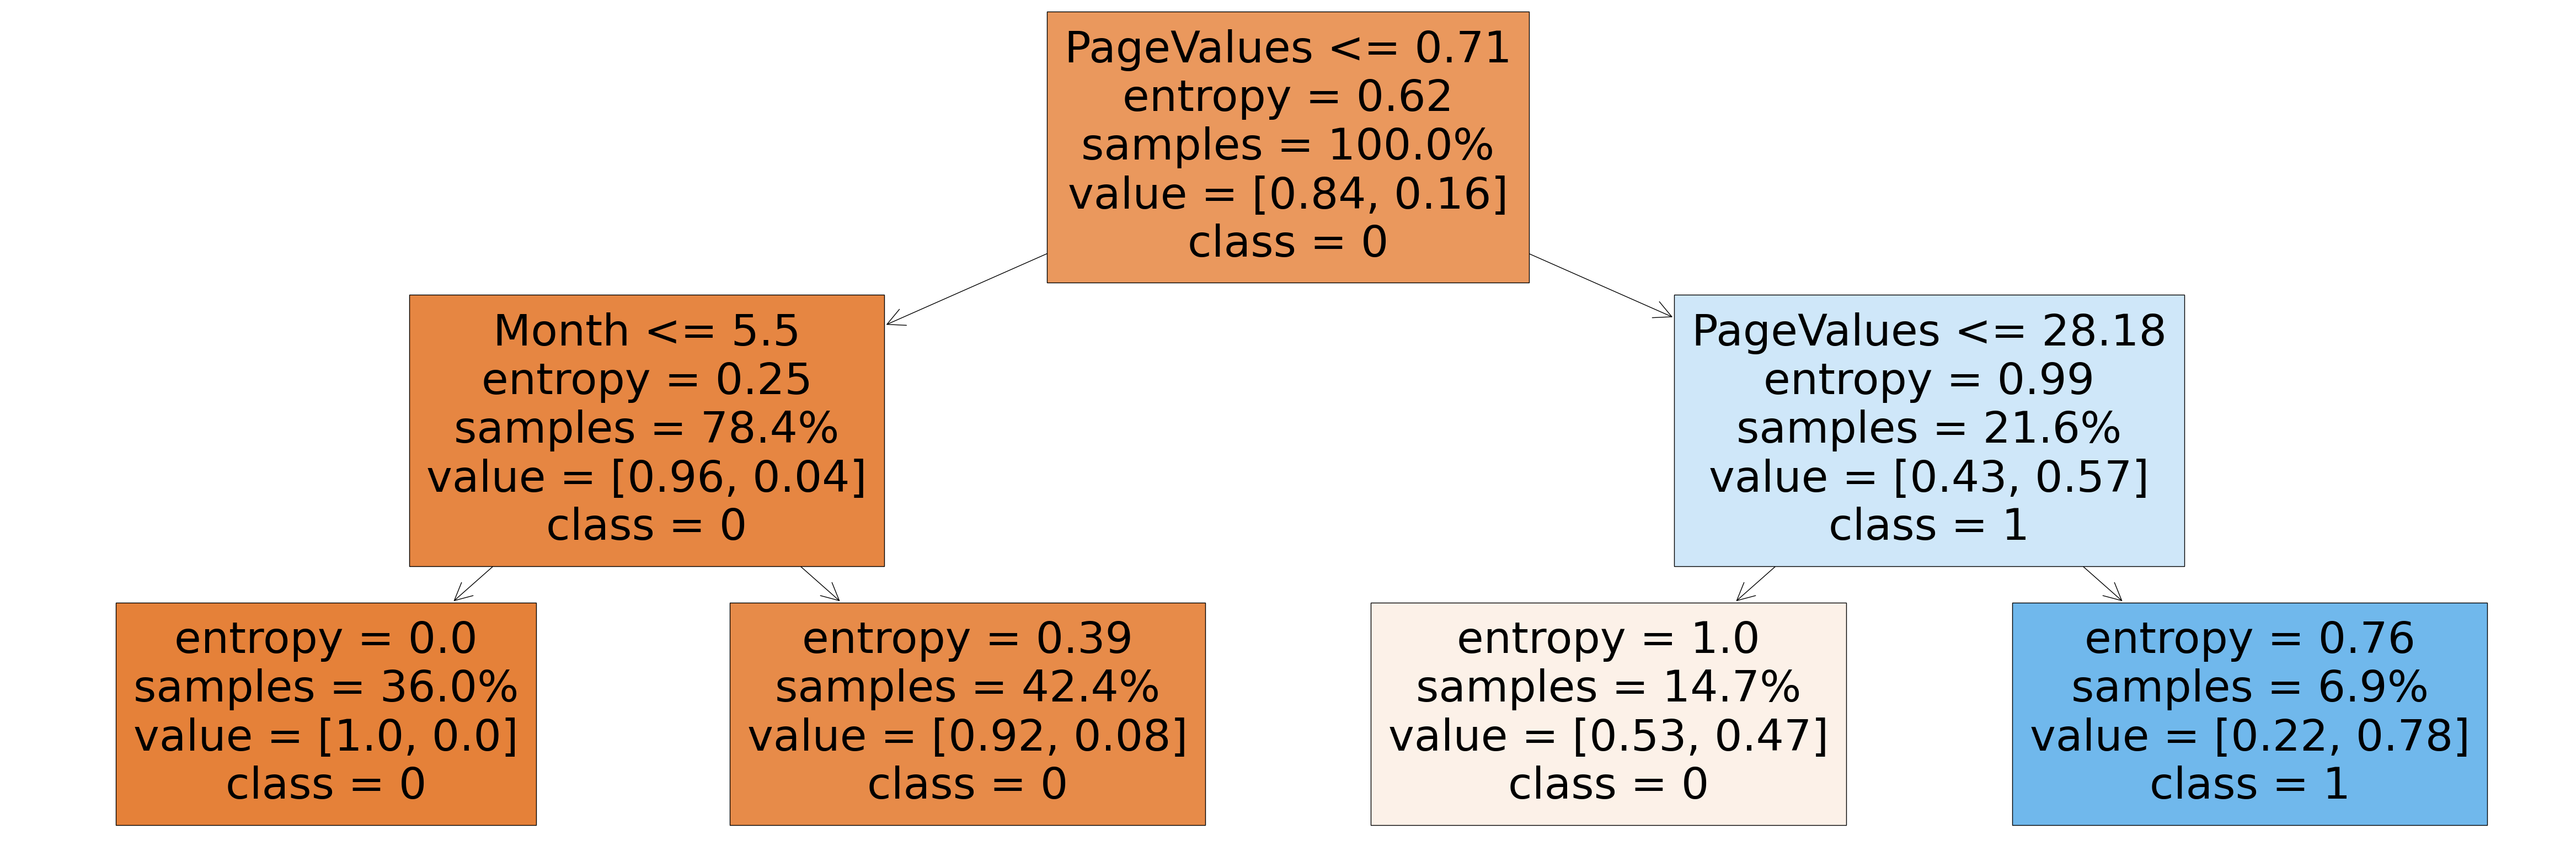

In [23]:
plot_tree_classification(tree, X_train)

### 7) Evaluate Generalization Performance

#### Investigating Performance Metrics

In [24]:
# predict target revenue with value 0 or 1
y_preds_class = tree.predict(X_test)
# predict probablility between 0 and 1 of target revenue 
y_preds_proba = tree.predict_proba(X_test)


In [25]:
print(classification_report(y_test, y_preds_class))

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      2809
         1.0       0.76      0.34      0.47       521

    accuracy                           0.88      3330
   macro avg       0.82      0.66      0.70      3330
weighted avg       0.87      0.88      0.86      3330



### Plotting Lift Curve

In [26]:
lift_tree = calculate_lift(y_test, y_preds_proba[:,1])


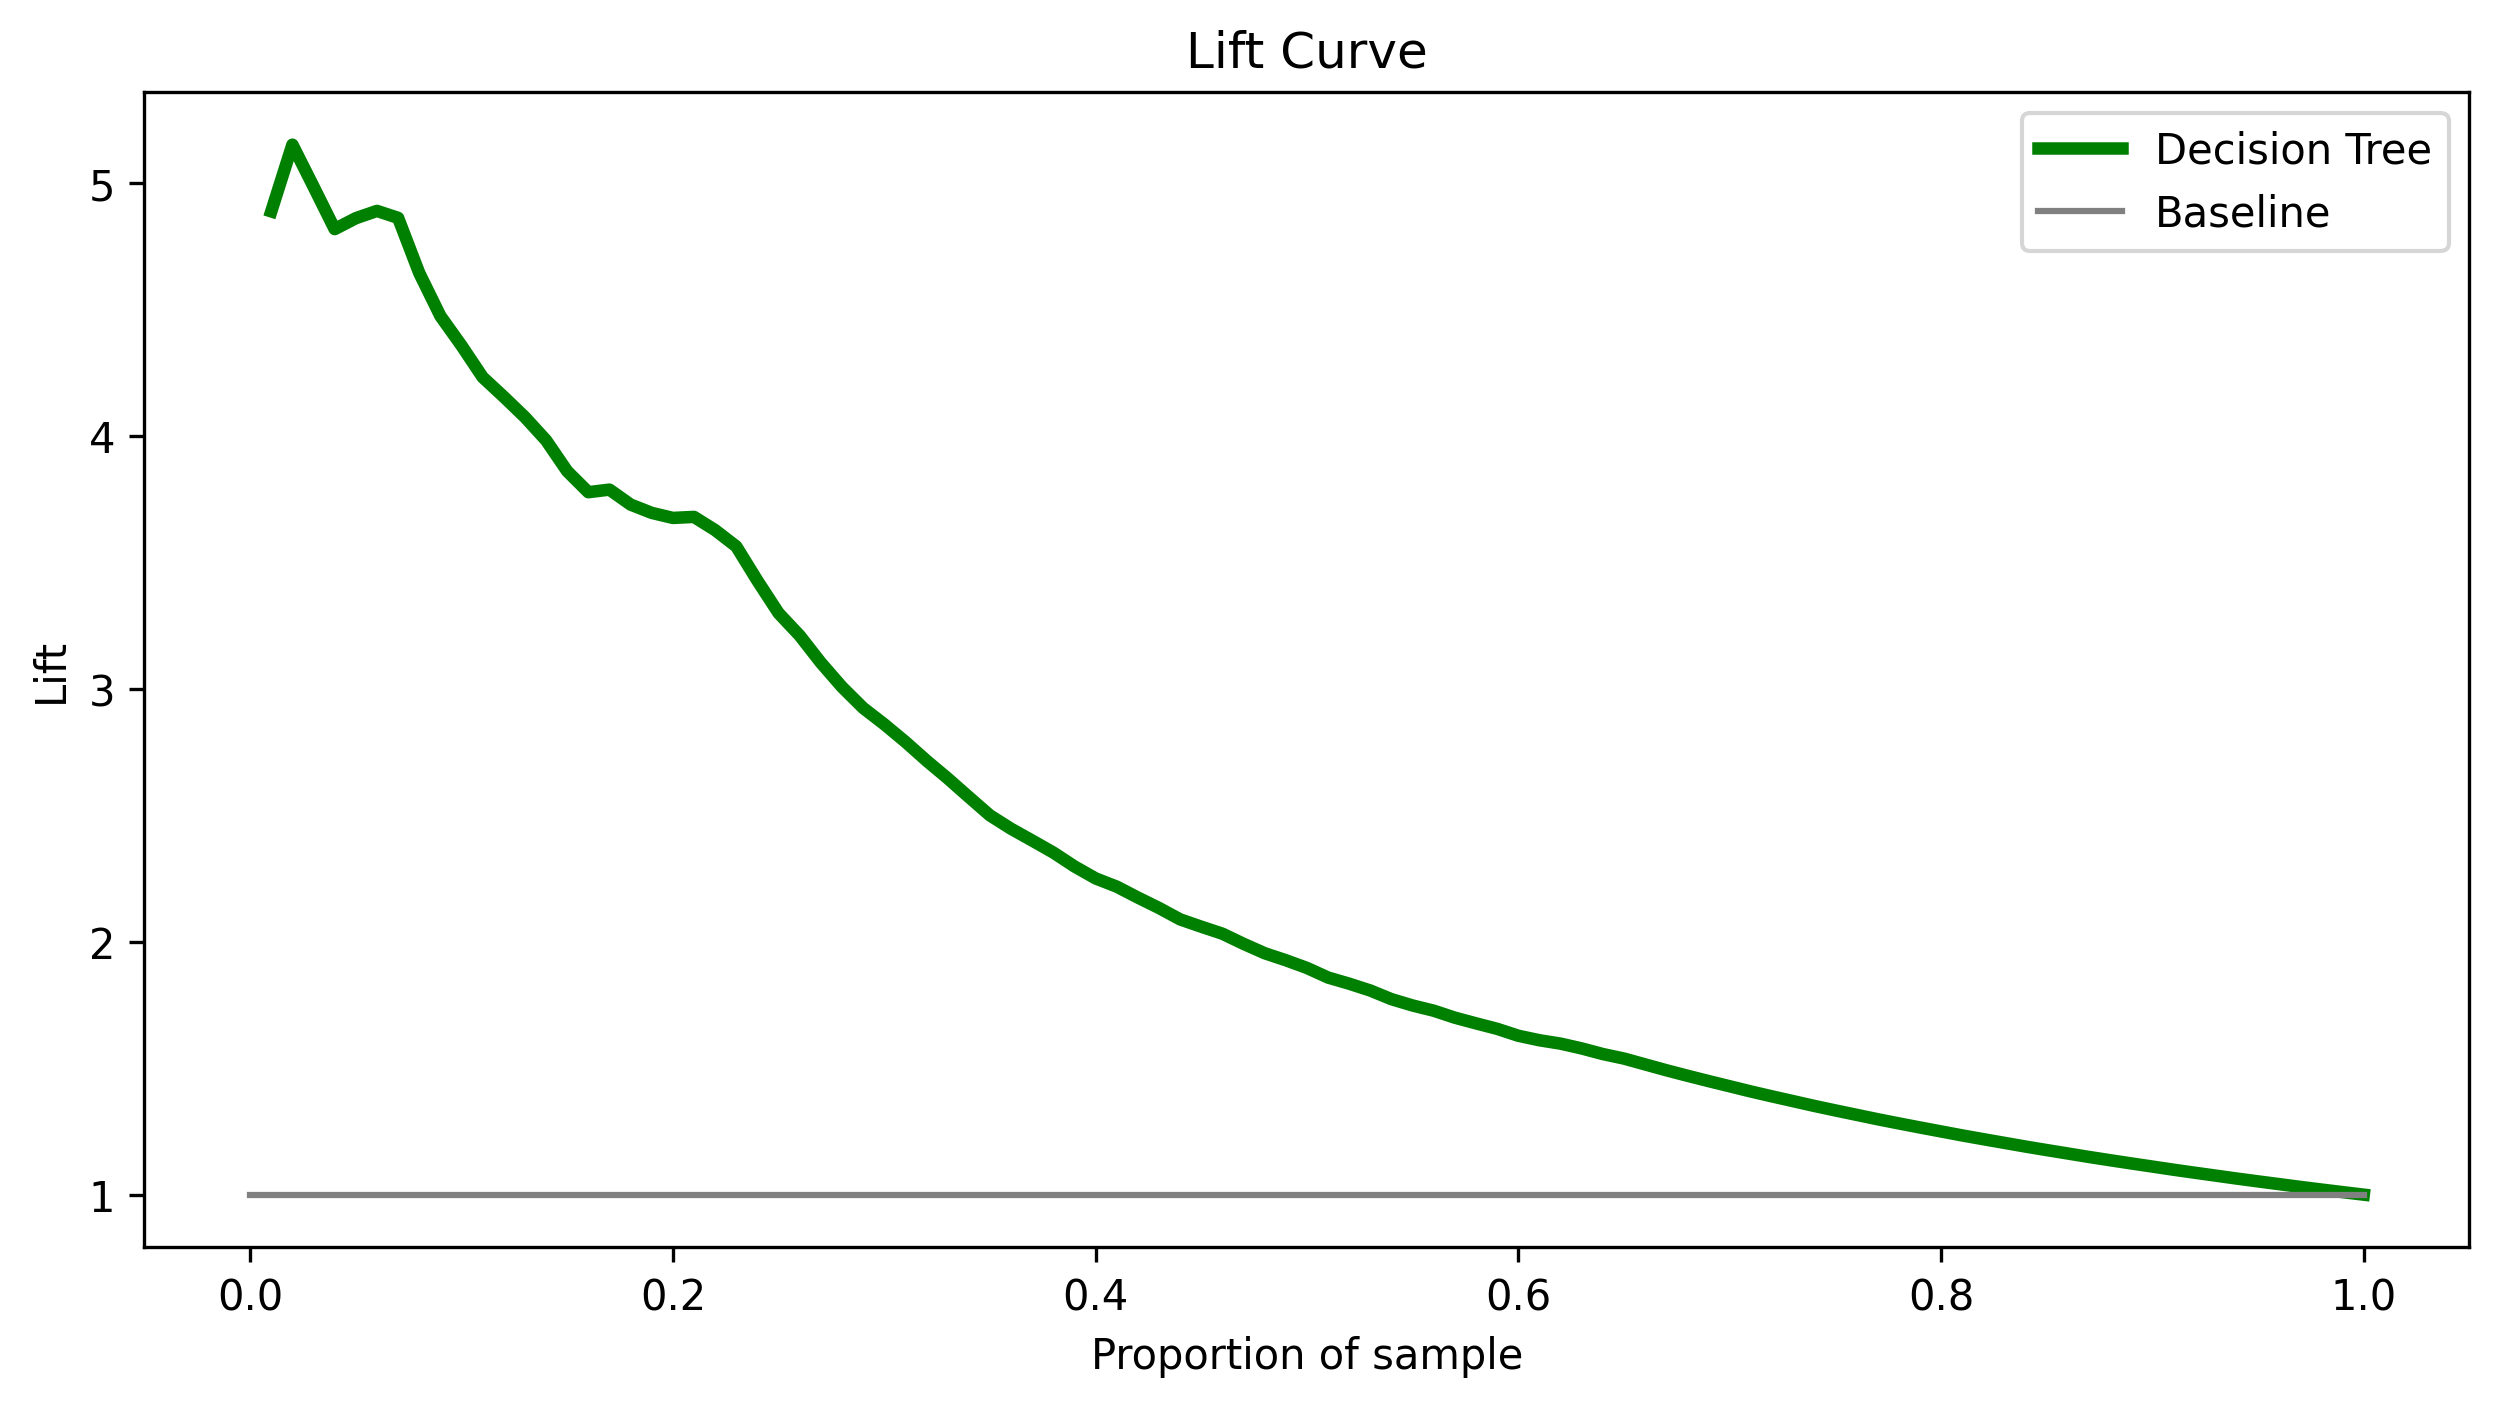

In [27]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
ax.plot(lift_tree["ProportionSample"], lift_tree["Lift"], color="green", linewidth=3, label="Decision Tree")
ax.plot([0,1],[1,1], color="grey", label="Baseline")
ax.set_xlabel("Proportion of sample")
ax.set_ylabel("Lift")
ax.set_title("Lift Curve")
ax.legend()
plt.show()

## 2. Hyperparameter Tuning & Cross validation of decision trees

### 1) Import model functions

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV #randomSearchCV selects combinations randomly, faster and almost as reliable as GridSearchCV
from sklearn.metrics import classification_report

### 2) Instantiate and Fit Model with Cross-Validation Setup

In [29]:
# set hyperparameter range
parameters = {"max_depth":range(1,30),
              "min_samples_leaf":[1, 10, 20, 30, 50, 100]}



In [30]:
tree_CV = GridSearchCV(DecisionTreeClassifier(criterion="entropy", random_state = 1), parameters, cv=5).fit(X_train, y_train)

In [31]:
tree_CV.best_params_

{'max_depth': 7, 'min_samples_leaf': 30}

### 3) Evaluate Model

In [32]:
y_pred_class_tree_CV = tree_CV.predict(X_test)
print(classification_report(y_test, y_pred_class_tree_CV))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      2809
         1.0       0.68      0.65      0.66       521

    accuracy                           0.90      3330
   macro avg       0.81      0.80      0.80      3330
weighted avg       0.89      0.90      0.90      3330



In [33]:
# predict with model and calculate lift values
y_preds_proba_tree_CV = tree_CV.predict_proba(X_test)
lift_tree_CV = calculate_lift(y_test, y_preds_proba_tree_CV[:,1])

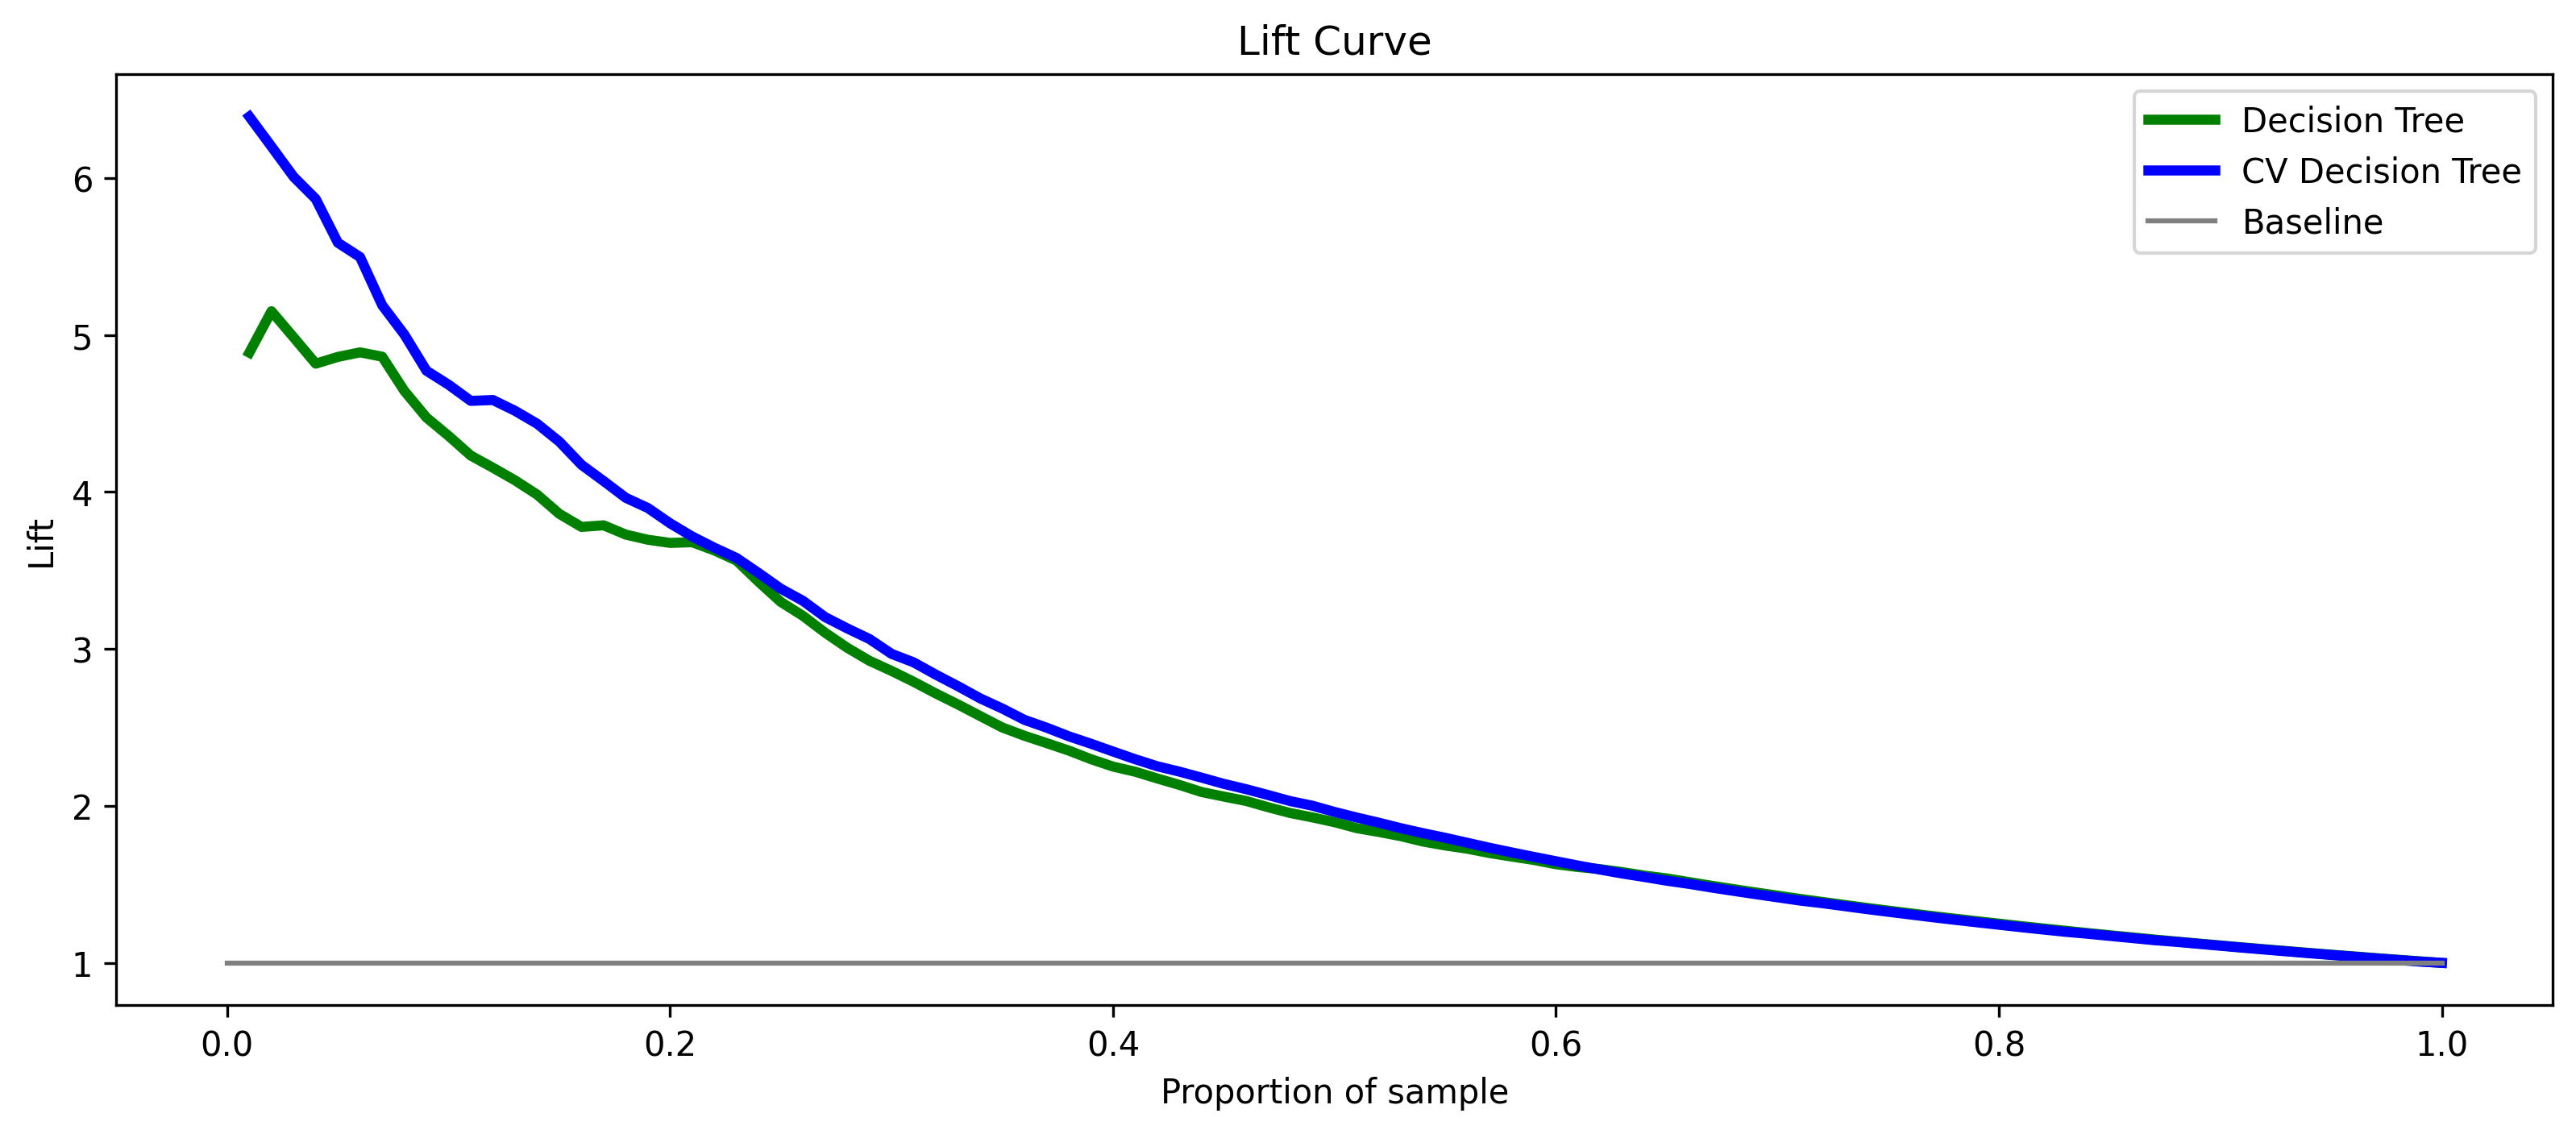

In [34]:
# plot lift curves
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color="blue", linewidth=3, label = "CV Decision Tree")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

## 3. Random Forests

### 1) Import Model Functions

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2) Instantiate and Fit Model 

In [36]:
forest = RandomForestClassifier(n_estimators = 2000).fit(X_train,y_train)

### 6) Interpret results

In [14]:
def plot_variable_importance(model, X_train):
    import matplotlib.pyplot as plt
    from pandas import DataFrame
    imp=DataFrame({"imp":model.feature_importances_, "names":X_train.columns}).sort_values("imp", ascending=True)
    fig, ax = plt.subplots(figsize=(imp.shape[0]/6,imp.shape[0]/5), dpi=300) 
    ax.barh(imp["names"],imp["imp"], color="green") 
    ax.set_xlabel('\nVariable Importance')
    ax.set_ylabel('Features\n') 
    ax.set_title('Variable Importance Plot\n') 
    plt.show() 

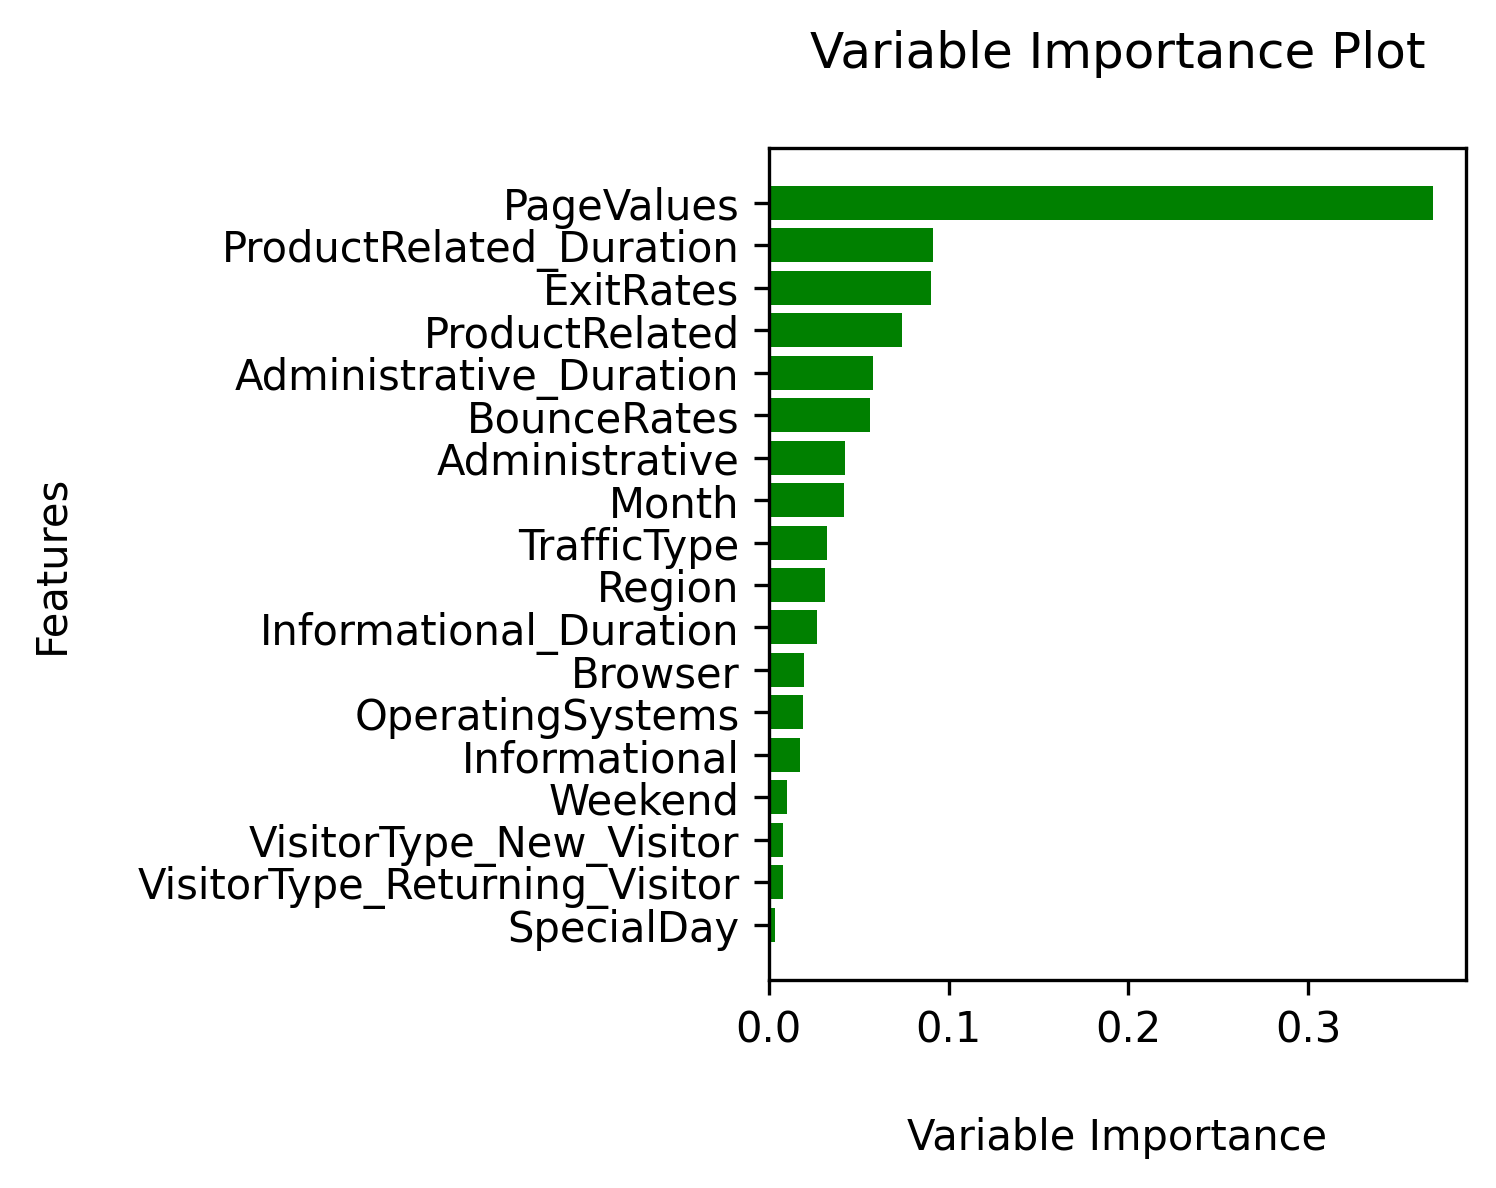

In [37]:
plot_variable_importance(forest, X_train)

### 7) Evaluate Performance 

In [38]:
y_pred_forest = forest.predict(X_test)
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2809
         1.0       0.75      0.57      0.65       521

    accuracy                           0.90      3330
   macro avg       0.84      0.77      0.80      3330
weighted avg       0.90      0.90      0.90      3330



In [39]:
y_preds_proba_forest = forest.predict_proba(X_test)
lift_forest= calculate_lift (y_test, y_preds_proba_forest[:,1])

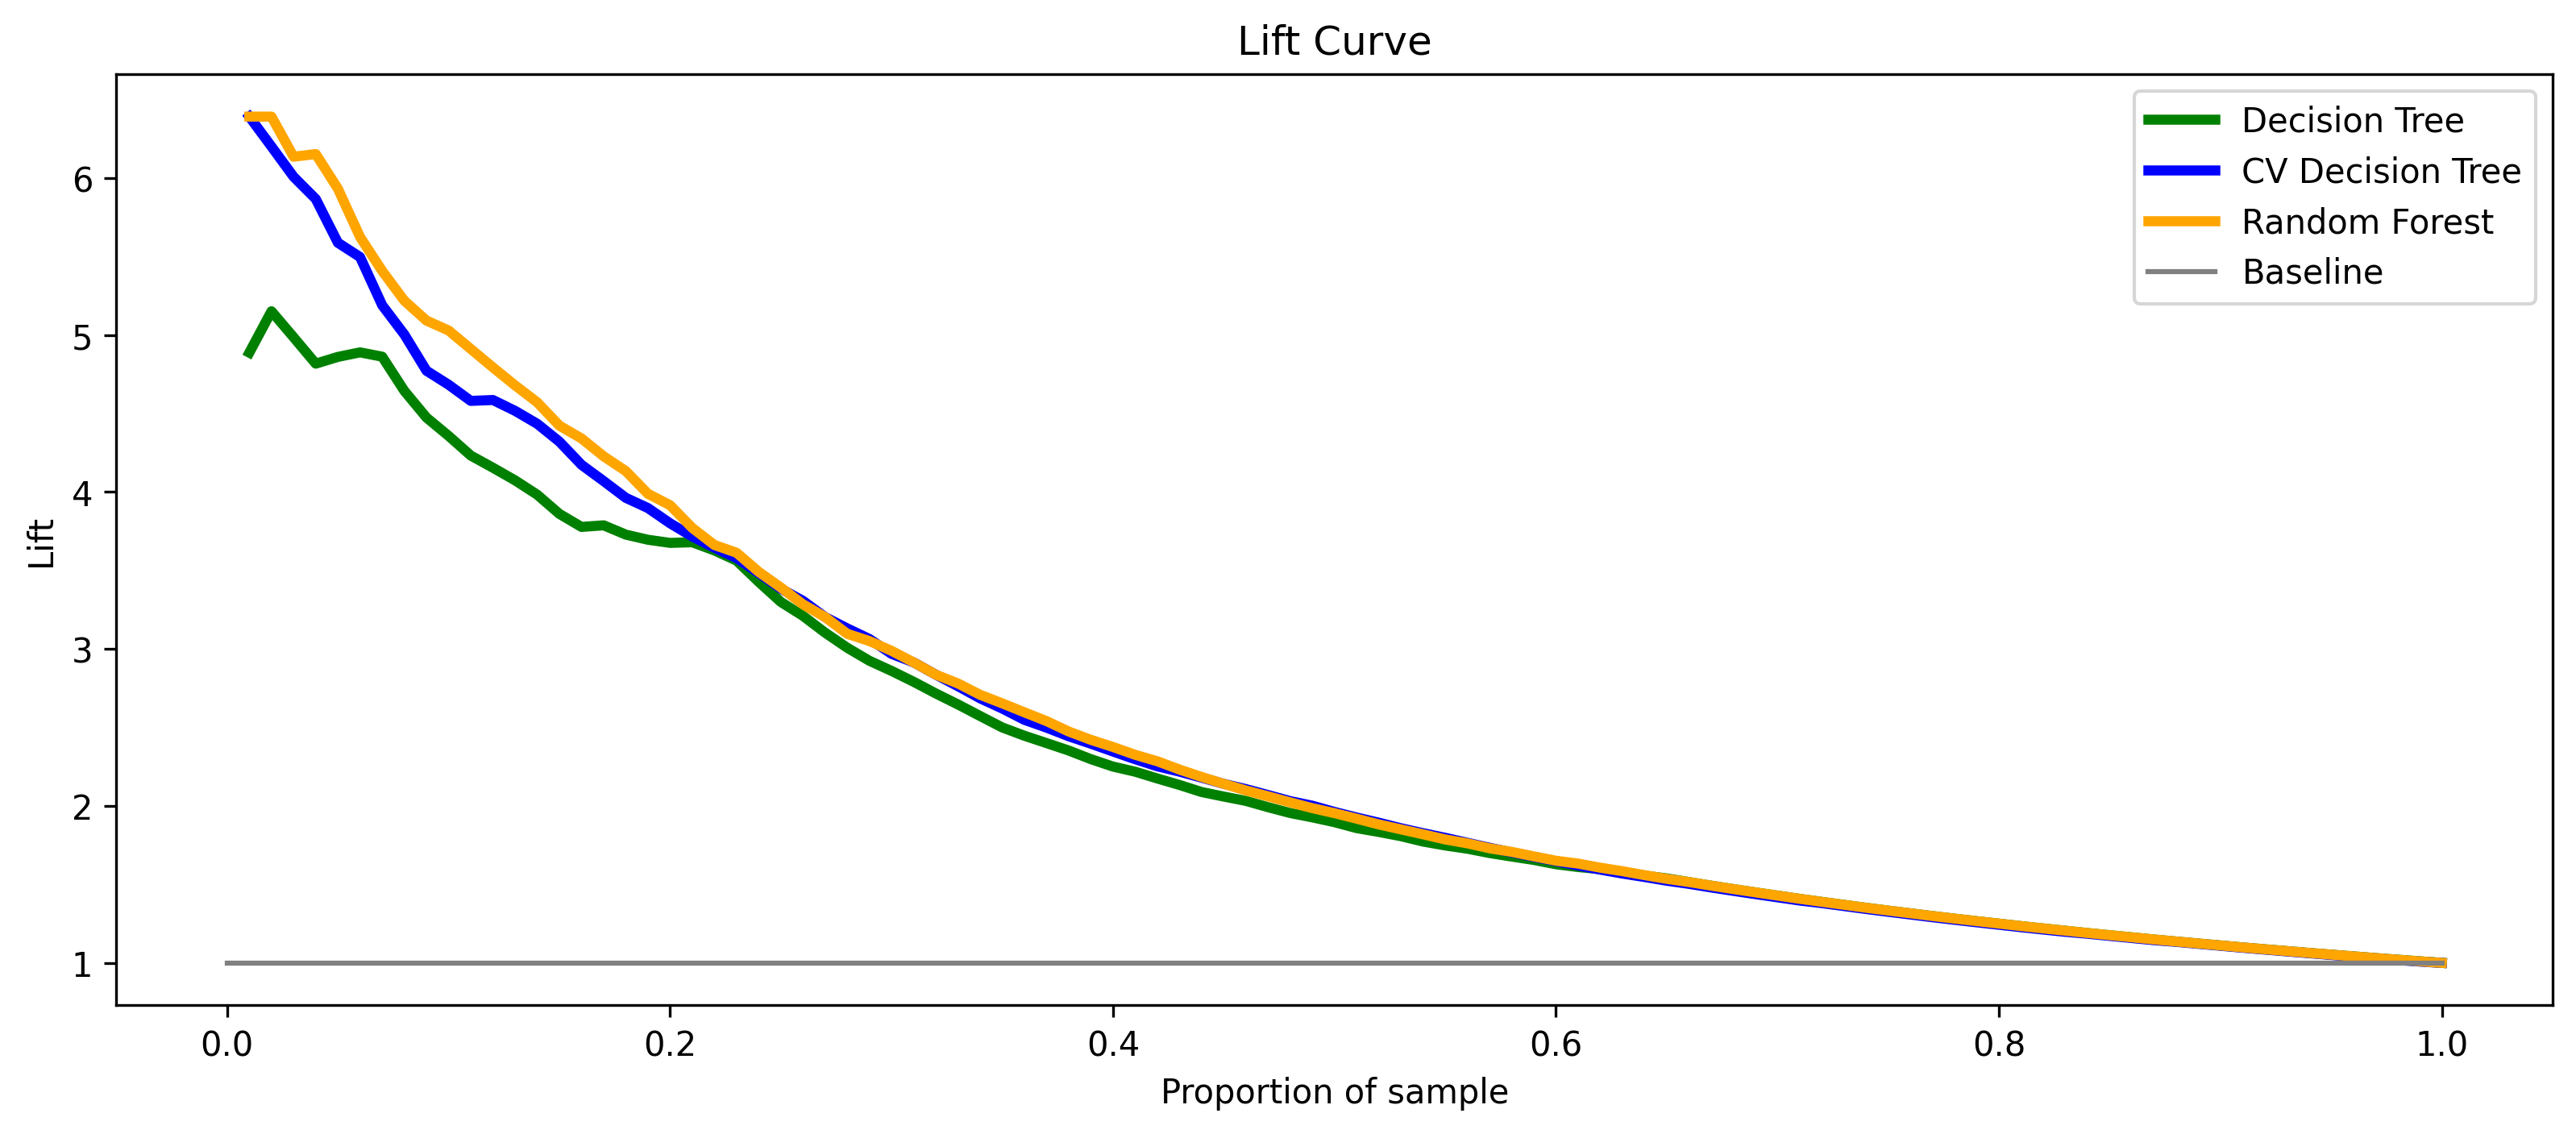

In [40]:
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"], lift_forest["Lift"], color="orange", linewidth = 3, label = "Random Forest" )
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

### Recursive feature elimination
we tried the recursive feature elimination for the our best model, the boosted trees but did´t get any performance increase by dropping the least important variable(s)

In [171]:
# recursive feature elimination 
from sklearn.feature_selection import RFE

selector = RFE(XGBClassifier(n_estimators=10), n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)
significance = selector.support_
significance


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True])

In [144]:
variables = X_train.columns
variables

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor'],
      dtype='object')

## 4. Boosted trees

### 1) Import Model Functions

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2) Create some trainsets with different sets of variables according to Recursive Feature Elimination

In [11]:
y = data["Revenue"]
X = data.drop("Revenue", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [172]:
X_reduced = data.drop(["Browser", "OperatingSystems", "Revenue"], axis=1)#[["PageValues", "ExitRates", "ProductRelated_Duration", "ProductRelated", "Administrative", "BounceRates", "Month", "Administrative_Duration", "TrafficType", "Region"]]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=1)

In [136]:
X_reduced = data[["PageValues", "ExitRates", "ProductRelated_Duration", "ProductRelated", "Administrative", "BounceRates", "Month", "Administrative_Duration", "TrafficType", "Region"]]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=1)

### 3) Instantiate Model
We also tried Cross Validaiton but it did not improve the performance and significantly increased runtime

In [42]:
boost = XGBClassifier(random_state = 1, max_depth=20, n_estimators=500, learning_rate=0.01, reg_alpha=6).fit(X_train, y_train)     

### 4) Interpret Results

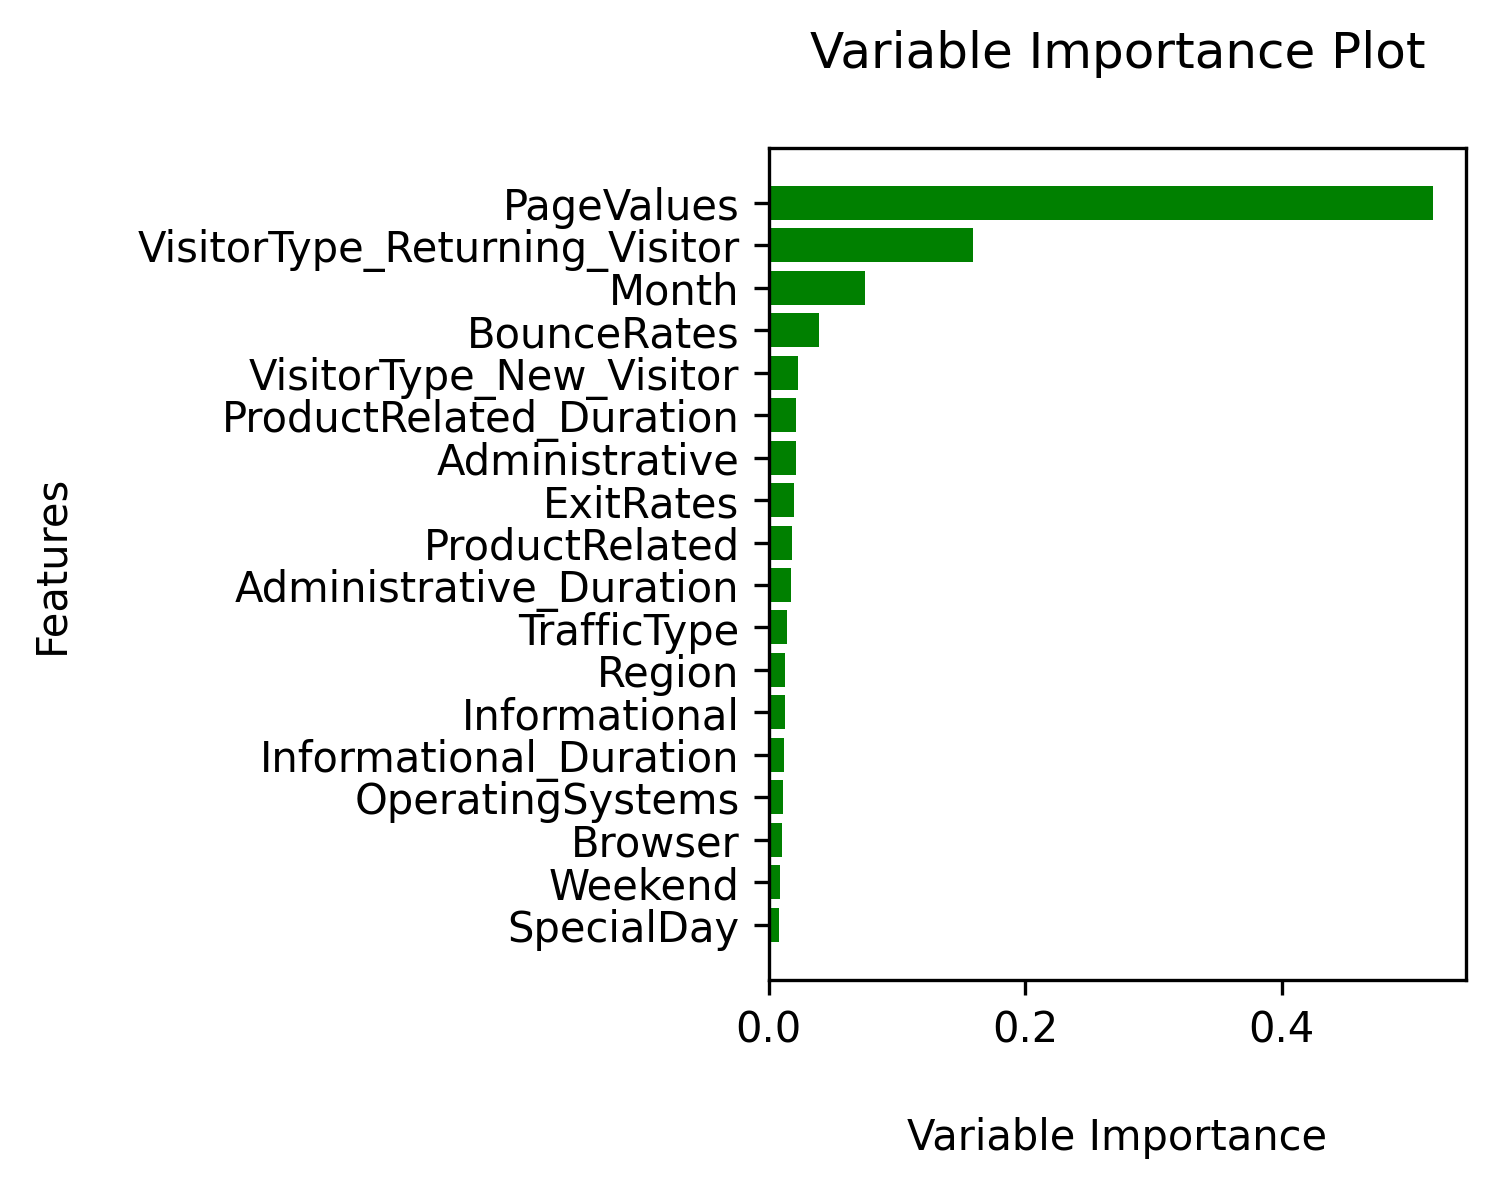

In [43]:
plot_variable_importance(boost, X_train)

### 7) Evaluate Generalization Performance

In [44]:
y_preds_class_boost = boost.predict(X_test)
print(classification_report(y_test,y_preds_class_boost))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      2809
         1.0       0.73      0.59      0.65       521

    accuracy                           0.90      3330
   macro avg       0.83      0.77      0.80      3330
weighted avg       0.89      0.90      0.90      3330



In [20]:
y_preds_test = boost.predict(test_data.drop(columns="Revenue"))
print(classification_report(test_data["Revenue"],y_preds_test))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1053
         1.0       0.74      0.62      0.67       180

    accuracy                           0.91      1233
   macro avg       0.84      0.79      0.81      1233
weighted avg       0.91      0.91      0.91      1233



Summary of Results

|Model|Precision|Recall|Accuracy|
|--|--|--|--|
|Decision Tree|0.76|0.34|0.88|
|CrossValidated Decision Tree|0.68|0.65|0.90|
|Random Forest|0.75|0.57|0.90|
|Gradient Boosted Trees|0.73|0.59|0.90|

In [45]:
y_preds_proba_boost = boost.predict_proba(X_test)
lift_boost = calculate_lift(y_test, y_preds_proba_boost[:,1])

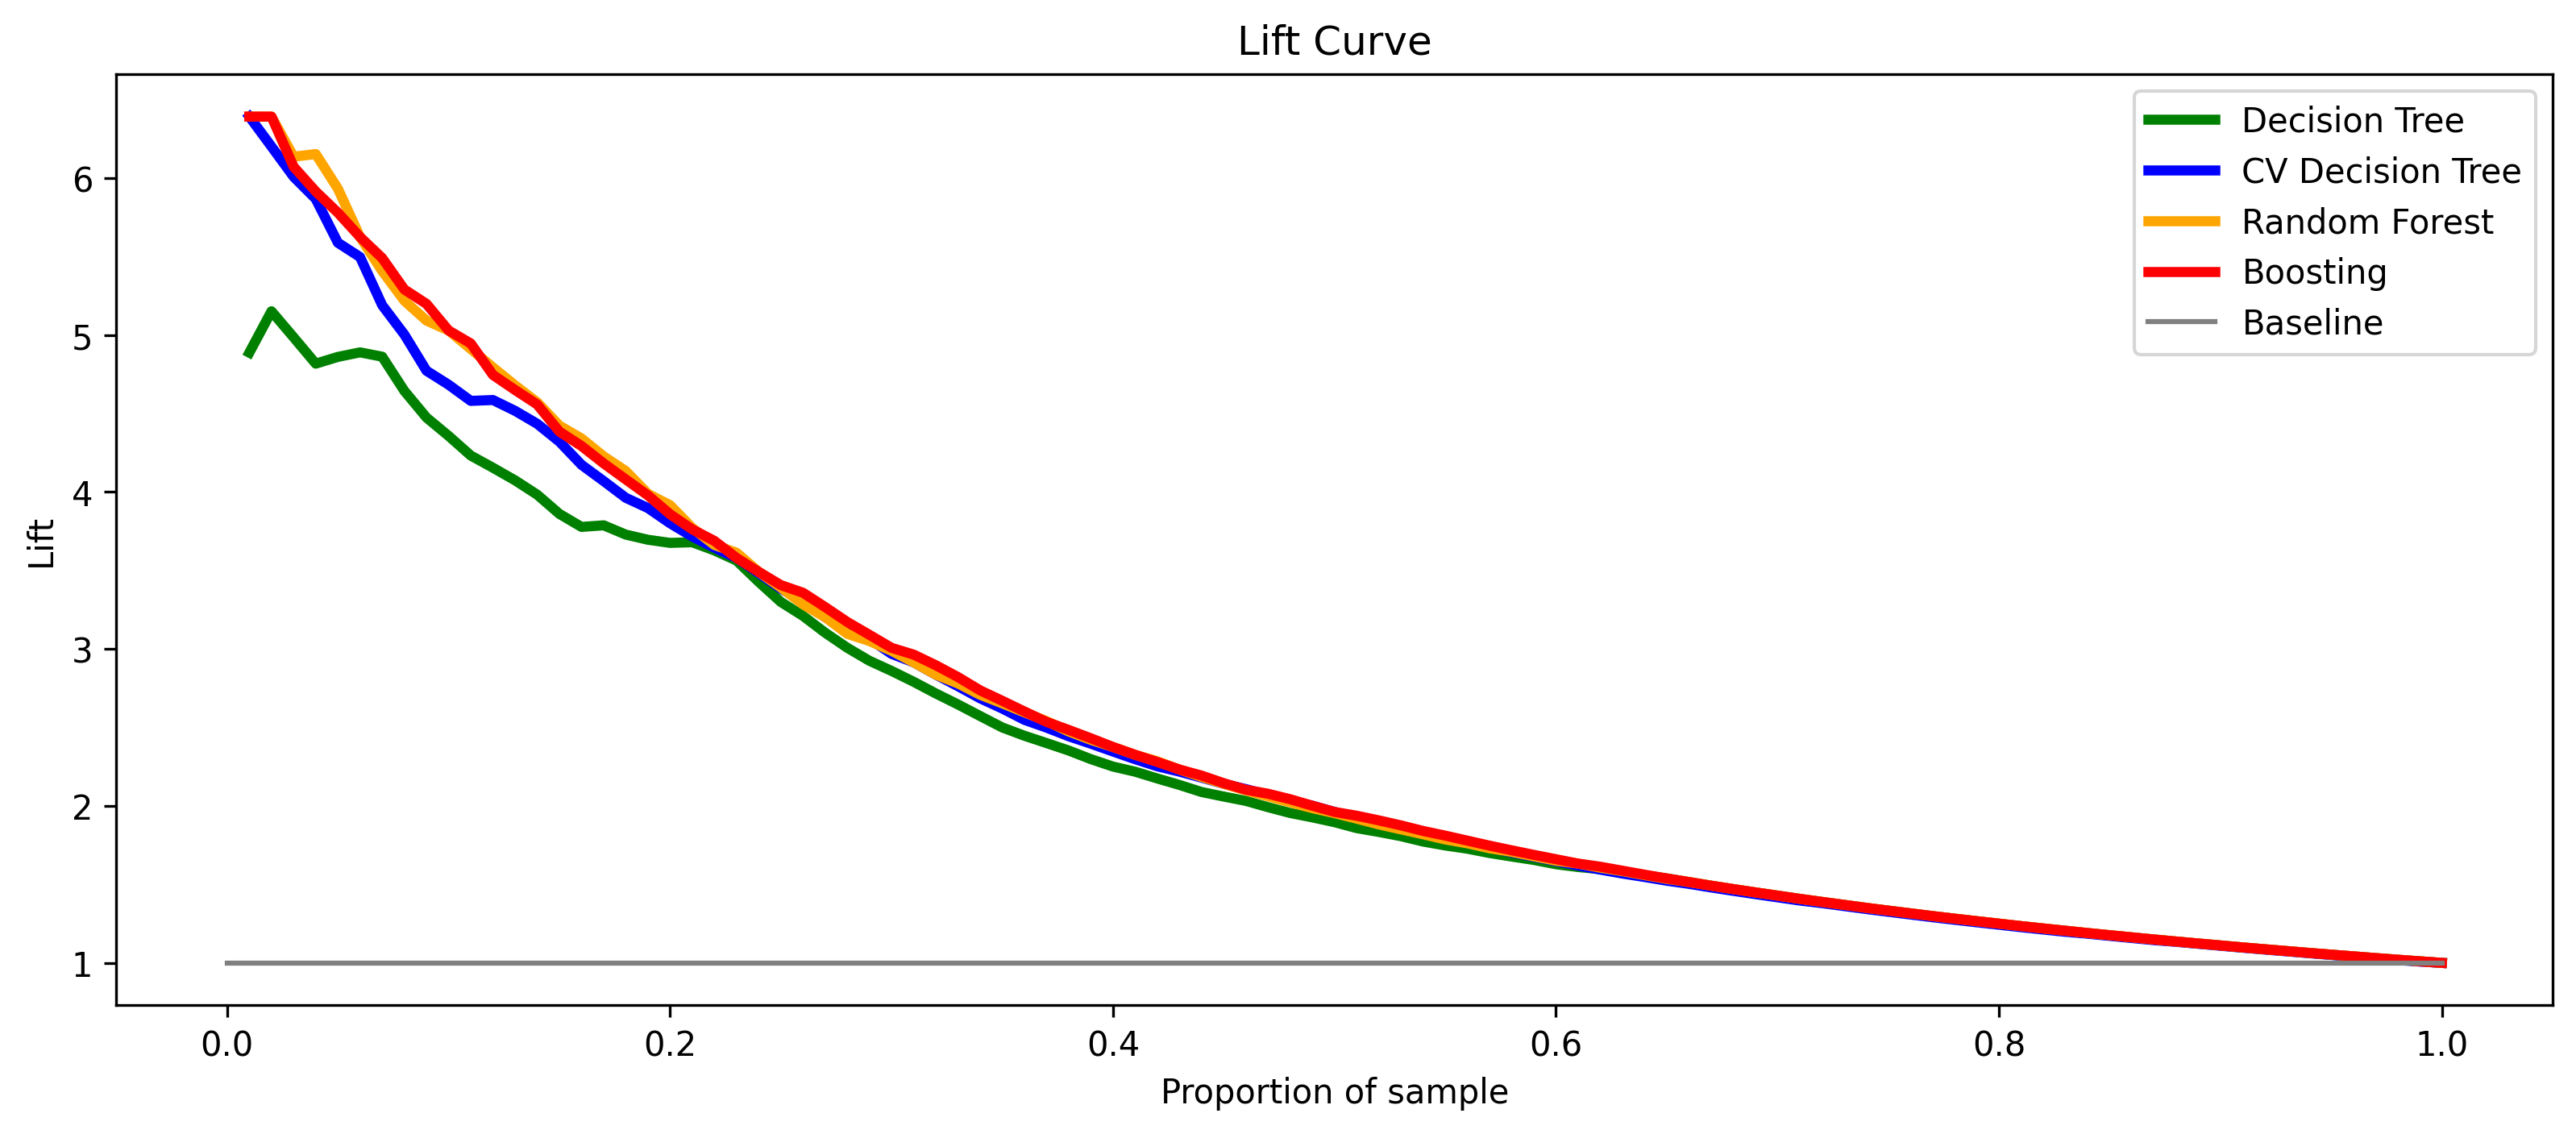

In [46]:
fig, ax = plt.subplots(figsize = (13,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"],lift_forest["Lift"], color='orange', linewidth = 3, label = "Random Forest")
ax.plot(lift_boost["ProportionSample"], lift_boost["Lift"], color="red", linewidth = 3, label = "Boosting")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('Proportion of sample')
ax.set_ylabel('Lift')
ax.set_title('Lift Curve')
ax.legend()
plt.show()

## 5. Stacking

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [57]:
estimators = [
    ('tree', tree),
    ('tree_CV', tree_CV),
    ('forest', forest),
    ('boost', boost)
]

stack = StackingClassifier(estimators).fit(X_train, y_train)

In [58]:
y_pred_stack = stack.predict(X_test)
print(classification_report(y_test,y_pred_stack))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      3149
         1.0       0.71      0.57      0.64       550

    accuracy                           0.90      3699
   macro avg       0.82      0.77      0.79      3699
weighted avg       0.90      0.90      0.90      3699



In [59]:
y_preds_proba_stack = stack.predict_proba(X_test)
lift_stack = calculate_lift(y_test, y_preds_proba_stack[:,1])

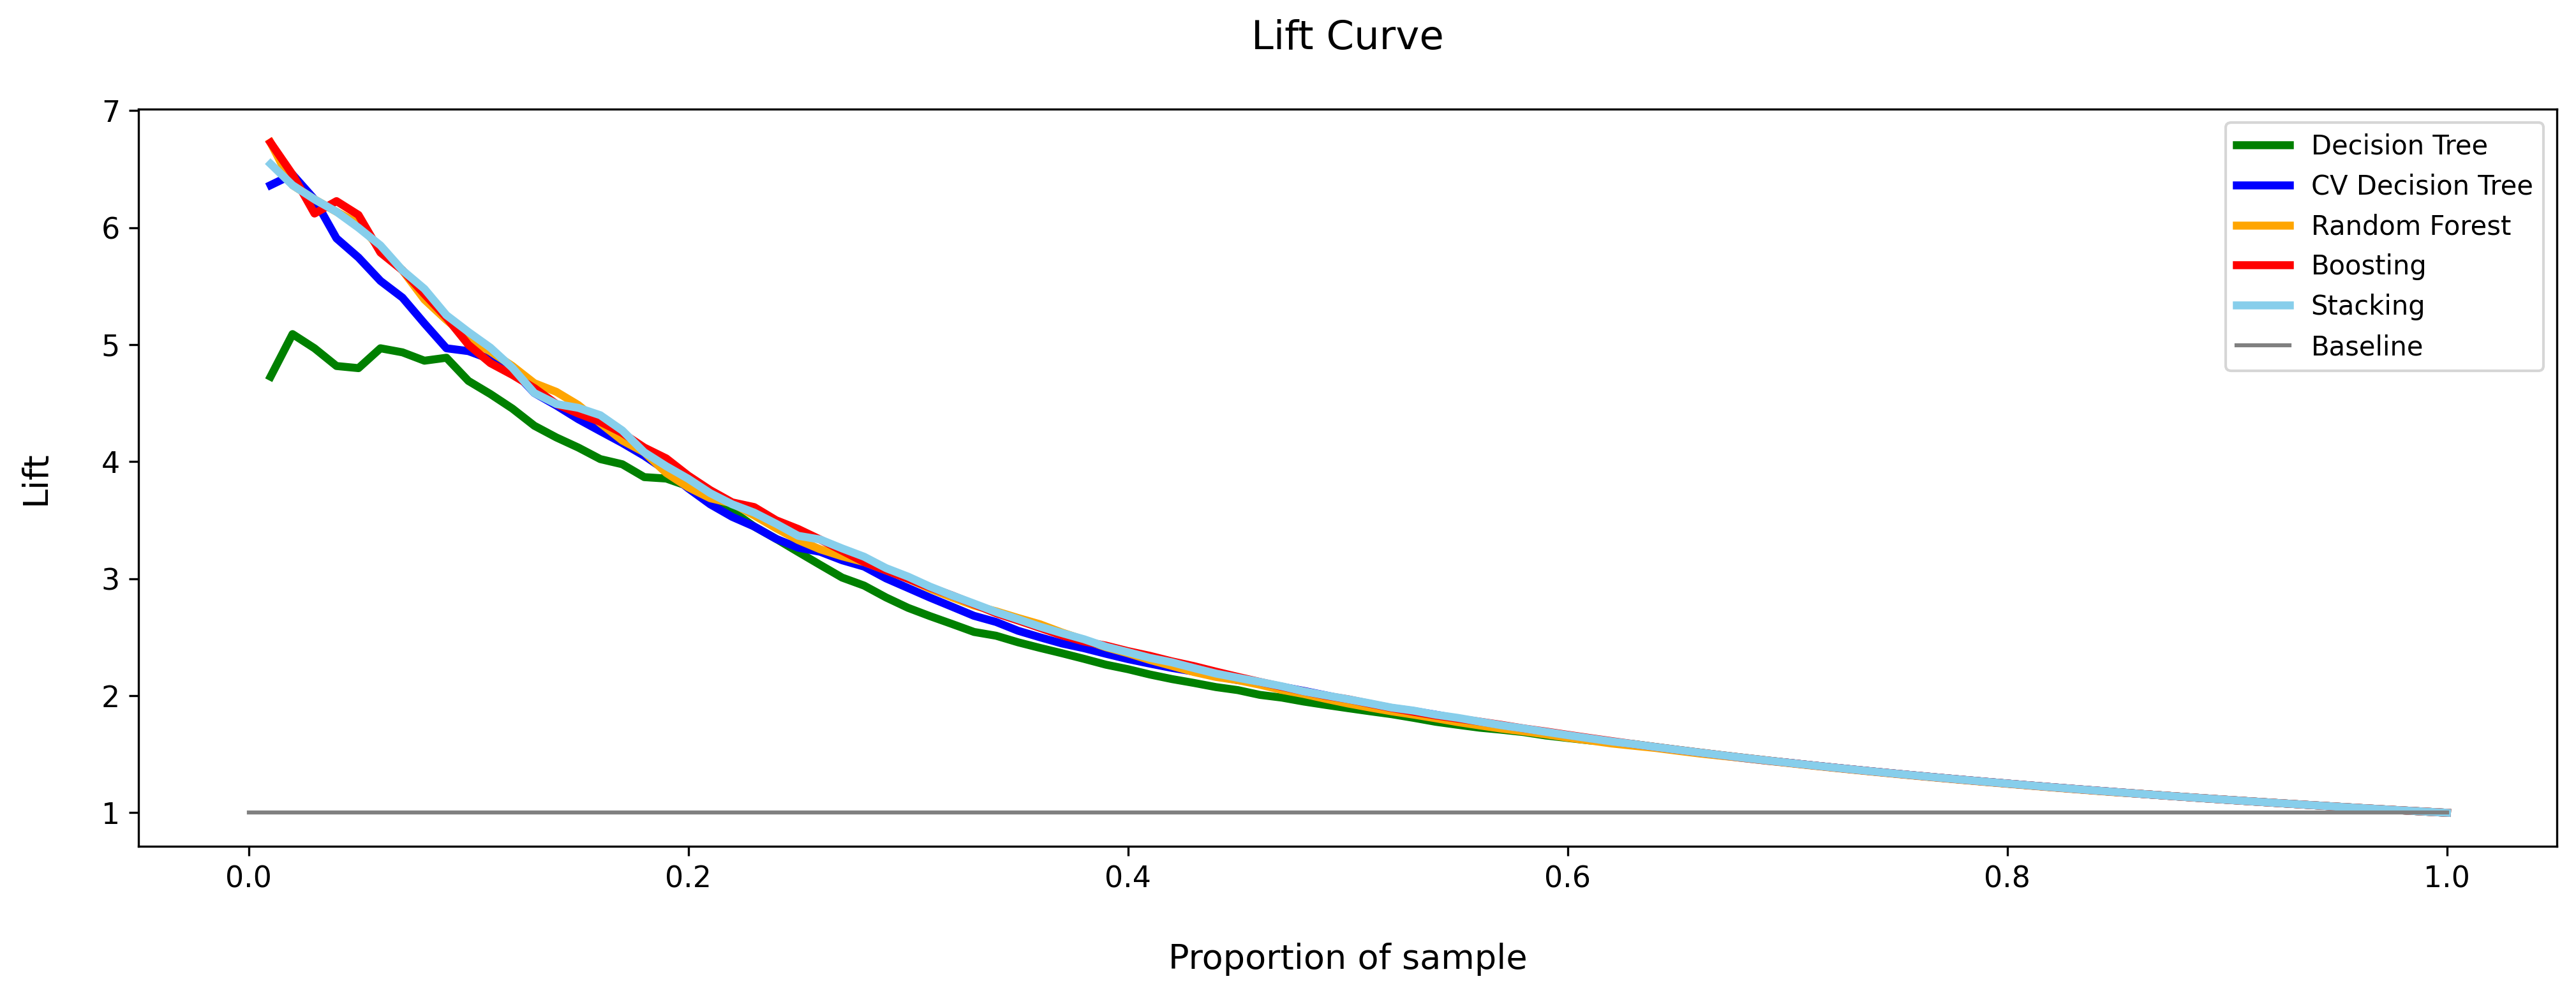

In [61]:
fig, ax = plt.subplots(figsize = (16.3,5), dpi=300)
ax.plot(lift_tree["ProportionSample"],lift_tree["Lift"], color='green', linewidth = 3, label = "Decision Tree")
ax.plot(lift_tree_CV["ProportionSample"],lift_tree_CV["Lift"], color='blue', linewidth = 3, label = "CV Decision Tree")
ax.plot(lift_forest["ProportionSample"],lift_forest["Lift"], color='orange', linewidth = 3, label = "Random Forest")
ax.plot(lift_boost["ProportionSample"],lift_boost["Lift"], color='red', linewidth = 3, label = "Boosting")
ax.plot(lift_stack["ProportionSample"],lift_stack["Lift"], color='skyblue', linewidth = 3, label = "Stacking")
ax.plot([0,1],[1,1],color="grey", label="Baseline")
ax.set_xlabel('\nProportion of sample', fontsize=13)
ax.set_ylabel('Lift\n', fontsize=13)
ax.set_title('Lift Curve\n', fontsize=15)

ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=11)
ax.legend()

plt.show()